In [ ]:
# Import all required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
from pathlib import Path

### Add Voltage Column to All Calibration Data
Convert ADC counts to voltage using ADS1115 with PGA 2/3 settings

In [ ]:
# ADS1115 with PGA 2/3 conversion parameters
# Full scale range: ±6.144V
# 16-bit ADC: -32768 to +32767
# Voltage = (ADC_counts / 32767) * 6.144

def adc_to_voltage(adc_counts):
    """Convert ADS1115 ADC counts to voltage with PGA 2/3"""
    return (adc_counts / 32767.0) * 6.144

# List of calibration CSV files to update
calibration_files = [
    'ph_calibration_2025-09-11_15-38-00.csv',
    'total_dissolved_solids_calibration_2025-09-18_15-13-46.csv',
    'turbidity_calibration_2025-09-18_12-24-36.csv'
]

# Process each calibration file
for filename in calibration_files:
    try:
        # Read the CSV file
        df = pd.read_csv(filename)

        # Check if ADC Counts column exists
        if 'ADC Counts' in df.columns:
            # Add voltage column right after ADC Counts
            adc_col_idx = df.columns.get_loc('ADC Counts')
            voltage_values = adc_to_voltage(df['ADC Counts'])

            # Insert voltage column
            df.insert(adc_col_idx + 1, 'Voltage (V)', voltage_values.round(6))

            # Save updated file
            df.to_csv(filename, index=False)
            print(f"✓ Updated {filename} with voltage column")

            # Display first few rows as verification
            print(f"  First 3 rows:")
            print(df.head(3))
            print()
        else:
            print(f"⚠ Warning: 'ADC Counts' column not found in {filename}")

    except FileNotFoundError:
        print(f"⚠ File not found: {filename}")
    except Exception as e:
        print(f"✗ Error processing {filename}: {e}")

print("Voltage column addition completed!")

✓ Updated ph_calibration_2025-09-11_15-38-00.csv with voltage column
  First 3 rows:
    pH  ADC Counts  Voltage (V)
0  3.0   15901.195     2.981565
1  3.0   16567.110     3.106428
2  3.0   16695.205     3.130446

✓ Updated total_dissolved_solids_calibration_2025-09-18_15-13-46.csv with voltage column
  First 3 rows:
   Total Dissolved Solids (ppm)  ADC Counts  Voltage (V)
0                         100.0        1261     0.236445
1                         100.0        1261     0.236445
2                         100.0        1261     0.236445

✓ Updated turbidity_calibration_2025-09-18_12-24-36.csv with voltage column
  First 3 rows:
   Turbidity (NTU)  ADC Counts  Voltage (V)
0              0.0       25655     4.810459
1              0.0       25667     4.812709
2              0.0       25649     4.809334

Voltage column addition completed!


### 3-Point Linear Fit for pH

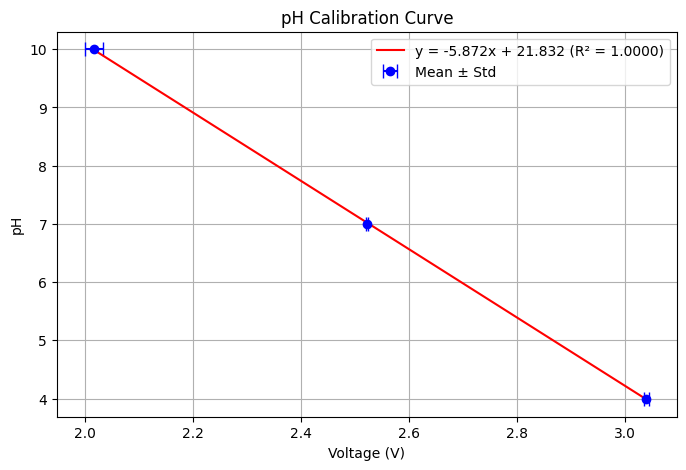

Fit coefficients: [-5.87169731 21.83201799]
R^2: 0.9999593490718925


In [ ]:
# Load data
df = pd.read_csv('ph_calibration_2025-09-11_15-38-00.csv')

# Exclude pH 3.0 and 9.0, then average each cluster
df_stats = (df[~df['pH'].isin([3.0, 9.0])].groupby('pH')['Voltage (V)'].agg(['mean', 'std']).reset_index())

# Fit and plot
x, y = df_stats['mean'].values, df_stats['pH'].values
yerr = df_stats['std'].values
coeffs = np.polyfit(x, y, 1)
p = np.poly1d(coeffs)
y_pred = p(x)
r2 = 1 - np.sum((y - y_pred)**2) / np.sum((y - np.mean(y))**2)

eqn = f"y = {coeffs[0]:.3f}x + {coeffs[1]:.3f} (R² = {r2:.4f})"

plt.figure(figsize=(8,5))
plt.errorbar(x, y, xerr=yerr, fmt='o', color='blue', label='Mean ± Std', capsize=5)
plt.plot(np.sort(x), p(np.sort(x)), color='red', label=eqn)
plt.xlabel('Voltage (V)')
plt.ylabel('pH')
plt.title('pH Calibration Curve')
plt.legend()
plt.grid(True)
plt.show()

print('Fit coefficients:', coeffs)
print('R^2:', r2)

In [ ]:
# Write to calibration.json
calib_path = Path('../calibration.json')
if calib_path.exists():
    with open(calib_path, 'r') as f:
        calibration = json.load(f)
else:
    calibration = {}

calibration['ph'] = {
    'coeffs': coeffs.tolist(),
    'degree': 1,
    'log': 'data/calibration-logs/ph_calibration_2025-09-11_15-38-00.csv'
}

with open(calib_path, 'w') as f:
    json.dump(calibration, f, indent=4)
print('Calibration coefficients written to calibration.json')

Calibration coefficients written to calibration.json


### 3-Point Linear Fit for Total Dissolved Solids

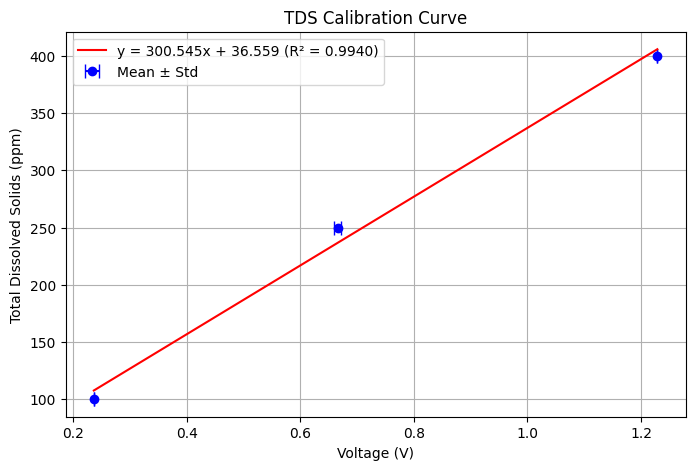

Fit coefficients: [300.54526497  36.55937483]
R^2: 0.9939519797820504


In [ ]:
# Load TDS data
tds = pd.read_csv('total_dissolved_solids_calibration_2025-09-18_15-13-46.csv')

# Average each cluster
tds_stats = tds.groupby('Total Dissolved Solids (ppm)')['Voltage (V)'].agg(['mean', 'std']).reset_index()

# Fit and plot
x, y = tds_stats['mean'].values, tds_stats['Total Dissolved Solids (ppm)'].values
yerr = tds_stats['std'].values
coeffs = np.polyfit(x, y, 1)
p = np.poly1d(coeffs)
y_pred = p(x)
r2 = 1 - np.sum((y - y_pred)**2) / np.sum((y - np.mean(y))**2)

eqn = f"y = {coeffs[0]:.3f}x + {coeffs[1]:.3f} (R² = {r2:.4f})"

plt.figure(figsize=(8,5))
plt.errorbar(x, y, xerr=yerr, fmt='o', color='blue', label='Mean ± Std', capsize=5)
plt.plot(np.sort(x), p(np.sort(x)), color='red', label=eqn)
plt.xlabel('Voltage (V)')
plt.ylabel('Total Dissolved Solids (ppm)')
plt.title('TDS Calibration Curve')
plt.legend()
plt.grid(True)
plt.show()
print('Fit coefficients:', coeffs)
print('R^2:', r2)

In [14]:
# Write to calibration.json
calib_path = Path('../calibration.json')
if calib_path.exists():
    with open(calib_path, 'r') as f:
        calibration = json.load(f)
else:
    calibration = {}

calibration['total_dissolved_solids'] = {
    'coeffs': coeffs.tolist(),
    'degree': 1,
    'log': 'data/calibration-logs/total_dissolved_solids_calibration_2025-09-18_15-13-46.csv'
}

with open(calib_path, 'w') as f:
    json.dump(calibration, f, indent=4)
print('TDS Calibration coefficients written to calibration.json')

TDS Calibration coefficients written to calibration.json


### 3-Point Quadratic Fit for Turbidity

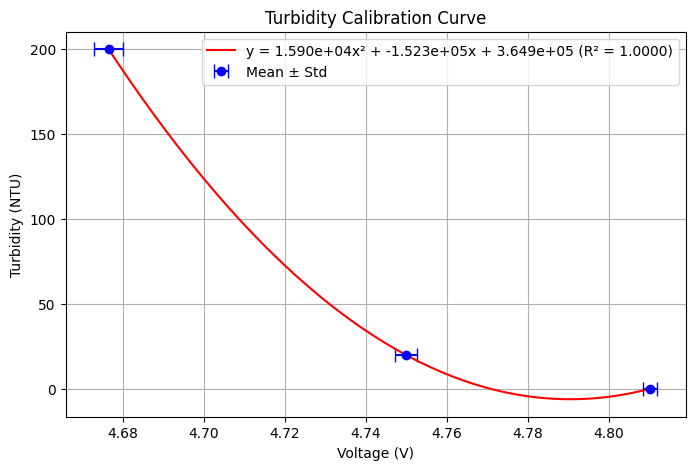

Fit coefficients: [  15899.48008261 -152330.95857921  364859.85019502]
R^2: 1.0


In [ ]:
# Load Turbidity data
turb = pd.read_csv('turbidity_calibration_2025-09-18_12-24-36.csv')

# Average each cluster and get std dev
turb_stats = turb.groupby('Turbidity (NTU)')['Voltage (V)'].agg(['mean', 'std']).reset_index()

# Fit and plot (degree 2, with error bars)
x, y = turb_stats['mean'].values, turb_stats['Turbidity (NTU)'].values
yerr = turb_stats['std'].values
coeffs = np.polyfit(x, y, 2)
p = np.poly1d(coeffs)
y_pred = p(x)
ss_res = np.sum((y - y_pred)**2)
ss_tot = np.sum((y - np.mean(y))**2)
r2 = 1 - ss_res / ss_tot

eqn = f"y = {coeffs[0]:.3e}x² + {coeffs[1]:.3e}x + {coeffs[2]:.3e} (R² = {r2:.4f})"

# Evaluate polynomial smoothly
x_smooth = np.linspace(x.min(), x.max(), 200)
y_smooth = p(x_smooth)

plt.figure(figsize=(8,5))
plt.errorbar(x, y, xerr=yerr, fmt='o', label='Mean ± Std', capsize=5, color='blue')
plt.plot(x_smooth, y_smooth, color='red', label=eqn)
plt.xlabel('Voltage (V)')
plt.ylabel('Turbidity (NTU)')
plt.title('Turbidity Calibration Curve')
plt.legend()
plt.grid(True)
plt.show()

print('Fit coefficients:', coeffs)
print('R^2:', r2)

In [ ]:
# Write to calibration.json
calib_path = Path('../calibration.json')
if calib_path.exists():
    with open(calib_path, 'r') as f:
        calibration = json.load(f)
else:
    calibration = {}

calibration['turbidity'] = {
    'coeffs': coeffs.tolist(),
    'degree': 2,
    'log': 'data/calibration-logs/turbidity_calibration_2025-09-18_12-24-36.csv'
}

with open(calib_path, 'w') as f:
    json.dump(calibration, f, indent=4)
print('Turbidity calibration coefficients written to calibration.json')

Turbidity calibration coefficients written to calibration.json
